In [42]:
"""
Read VIIRS active fire geolocation data (VNP03IMG)
Author: maxwell.cook@colorado.edu
"""

# Import packages
import sys, os
import xarray as xr
import pyproj
import geopandas as gpd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from netCDF4 import Dataset # to open NetCDF
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt
from affine import Affine
from osgeo import gdal, gdal_array, gdalconst, osr
from rasterio.transform import from_bounds
from scipy.spatial import cKDTree

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

# Projection information
geog = 'EPSG:4326'  # Geographic projection
prj = 'EPSG:5070'  # Projected coordinate system- WGS 84 NAD83 UTM Zone 13N

# File path information
maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')
# Output directories
dataraw = os.path.join(projdir,'data/spatial/raw/VIIRS/')
datamod = os.path.join(projdir,'data/spatial/mod/VIIRS/')

# File path information
print("Ready !")

Ready !


In [2]:
# Load fire data, extract the example fire (416)
fp = os.path.join(projdir,'data/spatial/mod/NIFC/nifc-ics_2018_to_2023-aspen_SRM.gpkg')
fires = gpd.read_file(fp)
fires.rename(columns={'NIFC_ID': 'Fire_ID'}, inplace=True)
perim = fires[fires['Fire_ID'] == '14'] # corresponds to the 416 fire
print(perim.columns)
print(perim.head())

Index(['Fire_ID', 'NIFC_NAME', 'NIFC_ACRES', 'FINAL_ACRES', 'pct_aspen',
       'INCIDENT_ID', 'INCIDENT_NAME', 'START_YEAR', 'CAUSE', 'DISCOVERY_DATE',
       'DISCOVERY_DOY', 'WF_CESSATION_DATE', 'WF_CESSATION_DOY',
       'STR_DESTROYED_TOTAL', 'STR_DAMAGED_TOTAL', 'STR_THREATENED_MAX',
       'EVACUATION_REPORTED', 'PEAK_EVACUATIONS', 'WF_PEAK_AERIAL',
       'WF_PEAK_PERSONNEL', 'na_l3name', 'geometry'],
      dtype='object')
  Fire_ID NIFC_NAME NIFC_ACRES FINAL_ACRES  pct_aspen       INCIDENT_ID  \
0      14       416   54130.98       54129  38.614463  2018_9091030_416   

  INCIDENT_NAME START_YEAR CAUSE      DISCOVERY_DATE  ... WF_CESSATION_DOY  \
0           416       2018     U 2018-06-01 11:02:00  ...              184   

  STR_DESTROYED_TOTAL STR_DAMAGED_TOTAL STR_THREATENED_MAX  \
0                   0                 0               3386   

  EVACUATION_REPORTED PEAK_EVACUATIONS WF_PEAK_AERIAL WF_PEAK_PERSONNEL  \
0                   1             2182             15    

In [3]:
# Grab an extent for cropping netcdf files
buffer = 1000 
coords, extent = get_coords(perim, buffer)
# Print the coordinates to verify
print(f"Bounding Coordinates: \n{coords}")
print(f"Bounding Extent: \n{extent}")

Bounding Coordinates: 
[(-108.0104287321153, 37.37737010107216), (-107.79428582032635, 37.37737010107216), (-107.79428582032635, 37.60899484292132), (-108.0104287321153, 37.60899484292132), (-108.0104287321153, 37.37737010107216)]
Bounding Extent: 
[-108.0104287321153, -107.79428582032635, 37.37737010107216, 37.60899484292132]


In [4]:
# Load the NetCDF files ...

In [5]:
# Get a list of .nc files
nc_files = list_files(os.path.join(projdir, f'data/spatial/raw/VIIRS/'), "*.nc", recursive=True)
# Seperate into VNP14 & VNP03
vnp = [f for f in nc_files if 'VNP14' in os.path.basename(f)] # VNP14IMG (active fire)
vnp03 = [f for f in nc_files if 'VNP03' in os.path.basename(f)] # VNP03IMG (geolocation)

print(f'VNP14IMG: {len(vnp)} granules')
print(f'VNP03IMG: {len(vnp03)} granules')

VNP14IMG: 94 granules
VNP03IMG: 94 granules


In [6]:
# Now operate on the entire fire ...

In [7]:
# Load the lookup table for pixel sizes
fp = os.path.join(projdir,'data/tabular/raw/pix_size_lut.csv')
lookup = pd.read_csv(fp)
print(lookup.head())

   sample  along_scan  along_track  scan_angle  pix_area
0       0    0.795616     0.783234     56.0600  0.623154
1       1    0.794690     0.782908     56.0511  0.622169
2       2    0.793765     0.782583     56.0422  0.621187
3       3    0.792842     0.782258     56.0333  0.620207
4       4    0.791921     0.781933     56.0244  0.619229


In [8]:
out_dfs = [] 
for fp in sorted(vnp)[0:5]:
    
    # Gather some metadata information from the file name
    timestamp = fp.split('.')[1:3]
    print(timestamp)
    year = timestamp[0][1:5]
    day = timestamp[0][5:8]
    time = timestamp[1]
    date = dt.datetime.strptime(year+day, '%Y%j').strftime('%b %d') 
    acq_date = dt.datetime.strptime(year+day, '%Y%j').strftime('%-m/%-d/%y') #match FIRMS
    daytime = int(time) > 1500 #timestamps in the 1900h-2200h UTC range are afternoon for Western US
    print(f"Acquisition date: {acq_date}")
    print(f"Acquisition datetime afternoon?: {daytime}")

    # Find matching geolocation data file for one record
    identifier = os.path.basename(fp)[:-3]
    parts = identifier.split('.') # split by '.'
    date_time_part = '.'.join(parts[1:4])  # Extract date-time parts for the VNP Version 002    
    geo_id = 'VNP03IMG' + '.' + date_time_part
    geo_da_fp = [geo_link for geo_link in vnp03 if geo_id in os.path.basename(geo_link)][0] 

    if geo_da_fp is None:
        print(f"!!! No geolocation file found for: {identifier}")
        continue
    
    # Read the geolocation data
    geo = xr.open_dataset(geo_da_fp, engine='netcdf4', group='geolocation_data')
    i, j = np.indices(geo.longitude.shape) #line and sample
    # Crop to fire bounding extent
    scene = ((geo.longitude > extent[0]) & (geo.longitude < extent[1]) & (geo.latitude > extent[2]) & (geo.latitude < extent[3])).values
    
    # Get the VNP14IMG fire mask, etc
    vnp14 = xr.open_dataset(fp, engine='netcdf4')

    qa = vnp14['algorithm QA']
    fire = vnp14['fire mask']
    daynight = vnp14.DayNightFlag #string Day or Night
    
    lonfp = vnp14.variables['FP_longitude'][:] # fire pixel longitude
    latfp = vnp14.variables['FP_latitude'][:]
    frp = vnp14.variables['FP_power'][:] # fire radiative power

    tree = cKDTree(np.array([lonfp, latfp]).T) #search tree for finding nearest FRP

    # Set up a pandas dataframe for the swath
    df = pd.DataFrame()
    df['longitude'] = list(geo.longitude.values[scene])
    df['latitude'] = list(geo.latitude.values[scene])
    df['fire_mask'] = list(fire.values[scene])
    df['daynight'] = daynight[0]
    df['confidence'] = df.fire_mask
    df.confidence = df.confidence.replace({0:'x', 1:'x', 2:'x', 3:'x', 4:'x', 5:'x', 6:'x', 7:'l', 8:'n', 9:'h'})
    df['acq_date'] = acq_date
    df['acq_time'] = time
    df['j'] = list(j[scene]) #sample number for pixel size lookup
    # df['height'] = list(geo.height.values[scene])
    # df['range'] = list(geo.range.values[scene])
    # df['sensor_azimuth'] = list(geo.sensor_azimuth.values[scene])
    # df['sensor_zenith'] = list(geo.sensor_zenith.values[scene])
    # df['solar_azimuth'] = list(geo.solar_azimuth.values[scene])
    # df['solar_zenith'] = list(geo.solar_zenith.values[scene])
    
    # Retain only low-high confidence fire points
    df = df[df['fire_mask'] > 6]
    df['fire_mask'] = pd.Categorical(df['fire_mask'])

    #gather frp
    known = df[df.confidence!='x']
    for k in known.index:
        dist, nearest = tree.query([ known.loc[k, 'longitude'], known.loc[k, 'latitude'] ])
        df.loc[k, 'frp'] = frp[nearest].item()

    # Join to pixel size info
    df = pd.merge(df, lookup, left_on='j', right_on='sample', how='left')
    df.drop(columns=['j'], inplace=True)
    out_dfs.append(df)
    
# Concat the output dfs
afds = pd.concat(out_dfs)

['A2018152', '1948']
Acquisition date: 6/1/18
Acquisition datetime afternoon?: True
['A2018153', '0806']
Acquisition date: 6/2/18
Acquisition datetime afternoon?: False
['A2018153', '0948']
Acquisition date: 6/2/18
Acquisition datetime afternoon?: False
['A2018153', '1924']
Acquisition date: 6/2/18
Acquisition datetime afternoon?: True
['A2018153', '2106']
Acquisition date: 6/2/18
Acquisition datetime afternoon?: True


In [9]:
afds.head()

,longitude,latitude,fire_mask,daynight,confidence,acq_date,acq_time,frp,sample,along_scan,along_track,scan_angle,pix_area
0,-107.809898,37.458965,8,D,n,6/1/18,1948,7.603679,4244,0.521187,0.415504,27.8788,0.216555
1,-107.810944,37.462734,9,D,h,6/1/18,1948,48.685238,4244,0.521187,0.415504,27.8788,0.216555
2,-107.815796,37.461769,7,D,l,6/1/18,1948,48.685238,4245,0.521516,0.415624,27.9055,0.216755
3,-107.820671,37.460793,8,D,n,6/1/18,1948,25.084015,4246,0.521845,0.415745,27.9322,0.216954
4,-107.816841,37.465534,9,D,h,6/1/18,1948,48.685238,4245,0.521516,0.415624,27.9055,0.216755


In [32]:
# Set up swath_gdf with original points
from shapely.geometry import Point
afds['geometry'] = [Point(xy) for xy in zip(afds.longitude, afds.latitude)]
swath_gdf = gpd.GeoDataFrame(afds, geometry='geometry', crs="EPSG:4326")

# Reproject to a projected CRS for accurate buffering
swath_gdf = swath_gdf.to_crs("EPSG:5070")

# Define the pixel buffer function for the given width and height
def pixel_buffer(point, width, height):
    half_width = width / 2
    half_height = height / 2
    return box(
        point.x - half_width, point.y - half_height,
        point.x + half_width, point.y + half_height
    )

# Apply the buffer function with along_scan and along_track values converted to meters
swath_gdf["geometry"] = swath_gdf.apply(
    lambda row: pixel_buffer(row["geometry"], row["along_scan"] * 1000, row["along_track"] * 1000),
    axis=1
)

swath_gdf = swath_gdf.reset_index(drop=True)
swath_gdf['obs_id'] = swath_gdf.index # unique ID column
swath_gdf.loc[:, 'acq_datetime'] = swath_gdf.apply(lambda row: convert_datetime(row['acq_date'], row['acq_time']), axis=1)

# swath_gdf is now a GeoDataFrame with buffered polygons in EPSG:5070
swath_gdf.head()

,longitude,latitude,fire_mask,daynight,confidence,acq_date,acq_time,frp,sample,along_scan,along_track,scan_angle,pix_area,geometry,obs_id,acq_datetime
0,-107.809898,37.458965,8,D,n,6/1/18,1948,7.603679,4244,0.521187,0.415504,27.8788,0.216555,"POLYGON ((-1031854.110 1666193.640, -1031854.1...",0,2018-06-01 19:48:00+00:00
1,-107.810944,37.462734,9,D,h,6/1/18,1948,48.685238,4244,0.521187,0.415504,27.8788,0.216555,"POLYGON ((-1031892.626 1666624.116, -1031892.6...",1,2018-06-01 19:48:00+00:00
2,-107.815796,37.461769,7,D,l,6/1/18,1948,48.685238,4245,0.521516,0.415624,27.9055,0.216755,"POLYGON ((-1032327.725 1666569.442, -1032327.7...",2,2018-06-01 19:48:00+00:00
3,-107.820671,37.460793,8,D,n,6/1/18,1948,25.084015,4246,0.521845,0.415745,27.9322,0.216954,"POLYGON ((-1032764.981 1666513.768, -1032764.9...",3,2018-06-01 19:48:00+00:00
4,-107.816841,37.465534,9,D,h,6/1/18,1948,48.685238,4245,0.521516,0.415624,27.9055,0.216755,"POLYGON ((-1032366.264 1666999.496, -1032366.2...",4,2018-06-01 19:48:00+00:00


In [33]:
out_fp = os.path.join(projdir,'data/spatial/mod/VIIRS/pix_area.gpkg')
swath_gdf.to_file(out_fp)

In [12]:
# Handle duplicate observations

In [13]:
# Case 1. Spatial overlap > 90% and the same acquisition time

In [35]:

# Find duplicates in space and time
drop_obs = set() # to store the observations we want to drop
for idx, obs in swath_gdf.iterrows():
    date_matches = swath_gdf[
        (swath_gdf['acq_datetime'] == obs['acq_datetime']) &
        (swath_gdf.obs_id != idx)
    ]
    if len(date_matches) > 0:
        for match_idx, match_obs in date_matches.iterrows():
            # Calculate overlap
            overlap_area = obs.geometry.intersection(match_obs.geometry).area
            ratio = overlap_area / obs.geometry.area
            # Check for >50% overlap
            if ratio > 0.50:
                # Keep the one with higher FRP, mark lower FRP for removal
                if match_obs['frp'] < obs['frp']:
                    drop_obs.add(match_idx)
                    break

swath_gdf_c1 = swath_gdf[~swath_gdf['obs_id'].isin(drop_obs)]
print(f"Identified a total of [{len(drop_obs)}/{len(swath_gdf)}] duplicate observations.")

out_fp = os.path.join(projdir,'data/spatial/mod/VIIRS/pix_area_case1.gpkg')
swath_gdf_c1.to_file(out_fp)
print(f"Saved to: {out_fp}")

Identified a total of [32/122] duplicate observations.
Saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/VIIRS/pix_area_case1.gpkg


In [15]:
# Case 2: Greater than 50% overlap, same day, different time.

In [36]:
time_threshold = timedelta(hours=5) # search for time within 5 hours

drop_obs = set()
for acq_date, group in swath_gdf_c1.groupby('acq_date'):
    for dn in ['D','N']:
        dn_group = group[group['daynight'] == dn].sort_values('acq_datetime')
        for idx, obs in dn_group.iterrows():
            time_matches = dn_group[
                (dn_group['acq_datetime'] > obs['acq_datetime']) &
                (dn_group['acq_datetime'] <= obs['acq_datetime'] + time_threshold) &
                (dn_group.index != idx)  # Exclude itself
            ]
            for match_idx, match_obs in time_matches.iterrows():
                # Calculate spatial overlap ratio
                overlap_area = obs.geometry.intersection(match_obs.geometry).area
                overlap_ratio = overlap_area / obs.geometry.area
                
                # Check for >50% spatial overlap
                if overlap_ratio > 0.50:
                    # Retain the highest FRP observation
                    if match_obs['frp'] < obs['frp']:
                        drop_obs.add(match_idx)
                        break

swath_gdf_c2 = swath_gdf_c1.drop(index=list(drop_obs)).reset_index(drop=True)
print(f"Identified a total of [{len(drop_obs)}/{len(swath_gdf_c1)}] overlapping observations within 5 hours, separated by day/night.")

out_fp = os.path.join(projdir, 'data/spatial/mod/VIIRS/pix_area_case2.gpkg')
swath_gdf_c2.to_file(out_fp)
print(f"Saved to: {out_fp}")

Identified a total of [11/90] overlapping observations within 5 hours, separated by day/night.
Saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/VIIRS/pix_area_case2.gpkg


In [ ]:
# Case 3: Classify first day of burn ("fire front" per se) and reburns

In [46]:
swath_gdf_c2['burn_class'] = 'front' # set the first day of burn / maximum FRP

# Sort by date and time to process chronologically
swath_gdf_c3 = swath_gdf_c2.sort_values(['acq_datetime']).reset_index(drop=True)
for idx, obs in swath_gdf_c3.iterrows():
    
    prev_obs = swath_gdf_c3.loc[:idx - 1]
    
    prev_obs = prev_obs[prev_obs['daynight'] == obs['daynight']]
    
    for prev_idx, _obs in prev_obs.iterrows():
        overlap = obs.geometry.intersection(_obs.geometry).area
        ratio = overlap / obs.geometry.area
        
        # If significant overlap is found, label based on FRP
        if ratio > 0.50:
            if obs['frp'] < _obs['frp']:
                swath_gdf_c3.at[idx, 'burn_class'] = 're-burn'
            else:
                swath_gdf_c3.at[prev_idx, 'burn_class'] = 'flare-up'

out_fp = os.path.join(projdir, 'data/spatial/mod/VIIRS/pix_area_case3.gpkg')
swath_gdf_c3.to_file(out_fp)
print(f"Saved to: {out_fp}")

Saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/VIIRS/pix_area_case3.gpkg


In [47]:
swath_gdf_c3['burn_class'].unique()

array(['front', 're-burn'], dtype=object)

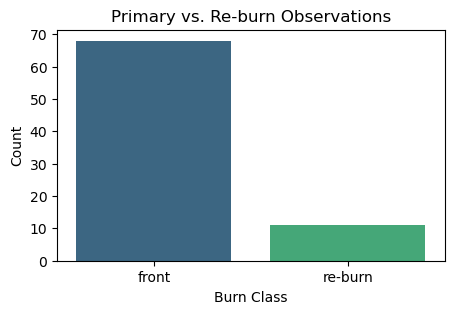

In [50]:
# Plot the distribution of "front" and "re-burn"
burn_class_counts = swath_gdf_c3['burn_class'].value_counts()

# Plot a bar chart
plt.figure(figsize=(5, 3))
sns.barplot(x=burn_class_counts.index, y=burn_class_counts.values, palette="viridis")
plt.title("Primary vs. Re-burn Observations")
plt.xlabel("Burn Class")
plt.ylabel("Count")
plt.show()

In [ ]:
# Open a .nc file ("file_name") to explore the contents
ds = Dataset(vnp[0], 'r', format = 'NETCDF4')
ds03 = Dataset(vnp03[0], 'r', format = 'NETCDF4')

print(f"VNP14IMG AFD granule:\n{ds}")
print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
print(f"VNP03IMG AFD granule:\n{ds03}")

In [ ]:
scan_line_attr = ds03.groups['scan_line_attributes']
geoloc_da = ds03.groups['geolocation_data'] # where the geolocation data is stored

print(list(scan_line_attr.variables))
print(list(geoloc_da.variables))

In [ ]:
# Retrieve the bounding coordinates from the geolocation file
latMin = ds03.getncattr('geospatial_lat_min')
latMax = ds03.getncattr('geospatial_lat_max')
lonMin = ds03.getncattr('geospatial_lon_min')
lonMax = ds03.getncattr('geospatial_lon_max')
print(f"Geospatial Lat/Lon Bounds:\n{[latMin, latMax, lonMin, lonMax]}")

In [ ]:
# Read the geolocation datasets (lat/lon)
geoloc_da = ds03.groups['geolocation_data'] # where the geolocation data is stored

# Retrieve the coordinates and land/water mask SDS from geolocation_data
var_da = geoloc_da.variables['land_water_mask'][:]  # a data array for land/water mask   
latitudes = geoloc_da.variables['latitude'][:]
longitudes = geoloc_da.variables['longitude'][:]

print(f"land/water mask: {var_da.shape}\nlatGEO shape: {lat.shape}\nlonGEO shape: {lon.shape}\nData Type: {type(lat)}")

In [ ]:
pixel_size_lat = (latMax - latMin) / latitudes.shape[0]
pixel_size_lon = (lonMax - lonMin) / longitudes.shape[1]

In [ ]:
from rasterio.transform import from_origin
transform = from_origin(lonMin, latMax, pixel_size_lon, pixel_size_lat)

In [ ]:
var_da_ = var_da.filled(np.nan)

In [ ]:
out_fp = os.path.join(datamod,'VNP03IMG_geolocation_grid.tif')
with rio.open(
    out_fp,
    "w",
    driver="GTiff",
    height=latitudes.shape[0],
    width=longitudes.shape[1],
    count=1,
    dtype='float32',
    crs="EPSG:4326",
    transform=transform,
) as dst:
    dst.write(var_da_, 1)

In [ ]:
from pyresample import geometry as geom

# Store the dimensions for later
dims = lat.shape # shape of the swath coordinate array
# Get the middle swath latlon
midLat, midLon = np.mean(lat), np.mean(lon) 

# Swath Definition from latlon arrays
swathDef = geom.SwathDefinition(lons=lon, lats=lat) # from 'pyresample' geom

# Create area definition using coordinate arrays and projection information
# Use info from aeqd bbox to calculate output cols/rows/pixel size
epsgConvert = pyproj.Proj("+proj=aeqd +lat_0={} +lon_0={}".format(midLat, midLon))
llLon, llLat = epsgConvert(np.min(lon), np.min(lat), inverse=False)
urLon, urLat = epsgConvert(np.max(lon), np.max(lat), inverse=False)
areaExtent = (llLon, llLat, urLon, urLat)
cols = int(round((areaExtent[2] - areaExtent[0])/375))  # 375 m pixel size
rows = int(round((areaExtent[3] - areaExtent[1])/375))
'''Use no. rows and columns generated above from the aeqd projection
            to set a representative number of rows and columns, which will then be translated
            to degrees below, then take the smaller of the two pixel dims to determine output size'''
epsg, proj, pName = '4326', 'longlat', 'Geographic'
llLon, llLat, urLon, urLat = np.min(lon), np.min(lat), np.max(lon), np.max(lat)
areaExtent = (llLon, llLat, urLon, urLat)
projDict = pyproj.CRS("epsg:4326") # geographic coordinate projection
areaDef = geom.AreaDefinition(epsg, pName, proj, projDict, cols, rows, areaExtent)
ps = np.min([areaDef.pixel_size_x, areaDef.pixel_size_y])  # Square pixels

# Now, recalculate the cols, rows, and area definition based on the pixel dimensions in degrees
cols = int(round((areaExtent[2] - areaExtent[0])/ps))  # Calculate the output cols
rows = int(round((areaExtent[3] - areaExtent[1])/ps))  # Calculate the output rows
areaDef = geom.AreaDefinition(epsg, pName, proj, projDict, cols, rows, areaExtent)
print(f"Pixel Dims: {ps};\nNumber of columns: {cols};\nNumber of rows: {rows}\nArea definition shape: {areaDef.shape}")

# Gather the geotransform definition
gt = [areaDef.area_extent[0], ps, 0, areaDef.area_extent[3], 0, -ps]
print(f"Geotransform: {gt}")

In [ ]:
out_fp = os.path.join(projdir,'data/spatial/mod/VIIRS/test_v2.tif')
with rio.open(
    out_fp,
    "w",
    driver="GTiff",
    height=rows,
    width=cols,
    count=1,
    dtype=var_da.dtype,
    crs="EPSG:4326",
    transform=Affine.from_gdal(*gt),
) as dst:
    dst.write(var_da, 1)
    print(f"Saved to: {out_fp}")

In [ ]:
lat_min, lat_max = 32.360493, 58.472694
lon_min, lon_max = -127.53604, -80.160385
n_rows, n_cols = latitude.shape
pixel_width = (lon_max - lon_min) / n_cols
pixel_height = (lat_max - lat_min) / n_rows
transform = Affine.translation(lon_min + pixel_width / 2, lat_max - pixel_height / 2) * Affine.scale(pixel_width, -pixel_height)

In [ ]:
n_rows, n_cols = latitude.shape
pixel_width = (longitude.max() - longitude.min()) / (n_cols - 1)
pixel_height = (latitude.max() - latitude.min()) / (n_rows - 1)
print(f"Pixel width: {pixel_width}\nPixel height: {pixel_height}")

In [ ]:
# transform = Affine.translation(longitude.min() - pixel_width / 2, latitude.max() + pixel_height / 2) * Affine.scale(pixel_width, -pixel_height)
# print(f"Geotransform:{transform}")

In [ ]:
day_night_flag = ds.getncattr('DayNightFlag')
print(day_night_flag)

In [ ]:
# Print a list of variables in file
print(list(ds.variables))
print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
print(list(ds03.variables))

In [ ]:
ds.getncattr('PlatformShortName')

In [ ]:
print(ds.variables[''])

In [ ]:
print(ds.variables['FP_confidence'][:])

In [ ]:
# Extract the acquisition date and time from the NetCDF file
start_time_str = ds.getncattr('PGE_StartTime')
acq_datetime = datetime.strptime(start_time_str, '%Y-%m-%d %H:%M:%S.%f')
# Calculate Julian Day
julian_day = acq_datetime.timetuple().tm_yday

print(f'Acquisition date/time: {acq_datetime}')
print(f'Acquisition Julian Day: {julian_day}')

In [ ]:
# Extract fire pixel information
latitudes = ds.variables['FP_latitude'][:]
longitudes = ds.variables['FP_longitude'][:]
fire_radiative_power = ds.variables['FP_power'][:]
fire_confidence = ds.variables['FP_confidence'][:]
day_night = ds.variables['FP_day'][:]

# Create a DataFrame with the fire pixel data
fire_data = pd.DataFrame({
    'latitude': latitudes,
    'longitude': longitudes,
    'fire_radiative_power': fire_radiative_power,
    'fire_confidence': fire_confidence,
    'day_night': day_night,
    'acq_datetime': acq_datetime,
    'acq_julian_day': julian_day
})

fire_data.head()

In [ ]:
print(len(fire_data))

In [ ]:
import folium
from folium.plugins import MarkerCluster

# Create a Folium map centered around the mean latitude and longitude
m = folium.Map(location=[fire_data['latitude'].mean(), fire_data['longitude'].mean()], zoom_start=6)

# Add a marker cluster to the map
marker_cluster = MarkerCluster().add_to(m)

# Add markers to the map
for idx, row in fire_data.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f'FRP: {row["fire_radiative_power"]}',
        icon=folium.Icon(color='red')
    ).add_to(marker_cluster)

# Display the map
m.save('fire_radiative_power_map.html')
m